In [2]:
import pickle
import sys
import spike.spike_analysis.single_cell as wilcox
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
import importlib
import spike.spike_analysis.spike_recording as rec
import spike.spike_analysis.spike_collection as sc
import plotly.graph_objects as go
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    


In [ ]:
novel_collection = sc.SpikeCollection.load_collection('pilot2/habit_dishabit_phase1/novel_collection/spike_collection.json')
cagemate_collection = sc.SpikeCollection.load_collection('pilot2/habit_dishabit_phase1/cagemate_collection/spike_collection.json')




All set to analyze
All set to analyze


In [11]:
novel_collection.analyze(timebin = 100, ignore_freq=0.5)
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5)

All set to analyze
All set to analyze


# Neurons per recording

In [9]:
total_neurons = 0
total_good_neurons = 0
for recording in cagemate_collection.recordings: 
    total_neurons += len(recording.freq_dict.keys())
    for neuron, freq in recording.freq_dict.items():
        if freq > 0.45:
            total_good_neurons += 1
        else:
            pass    
print(total_good_neurons, total_neurons)   
      

138 164


In [10]:
total_neurons = 0
total_good_neurons = 0
for recording in novel_collection.recordings: 
    total_neurons += len(recording.freq_dict.keys())
    for neuron, freq in recording.freq_dict.items():
        if freq > 0.45:
            total_good_neurons += 1
        else:
            pass    
print(total_good_neurons, total_neurons)   
      

131 145


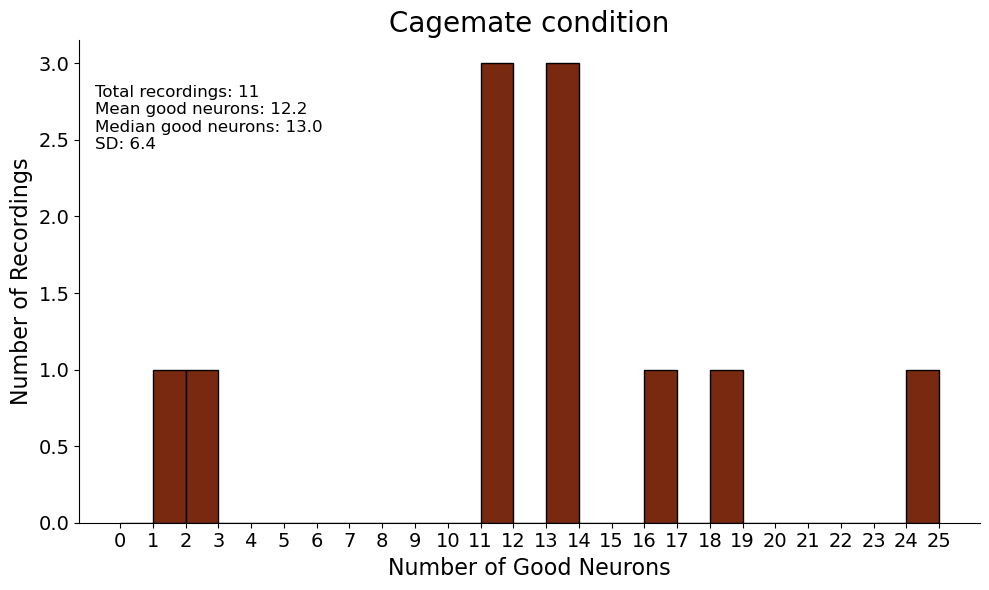

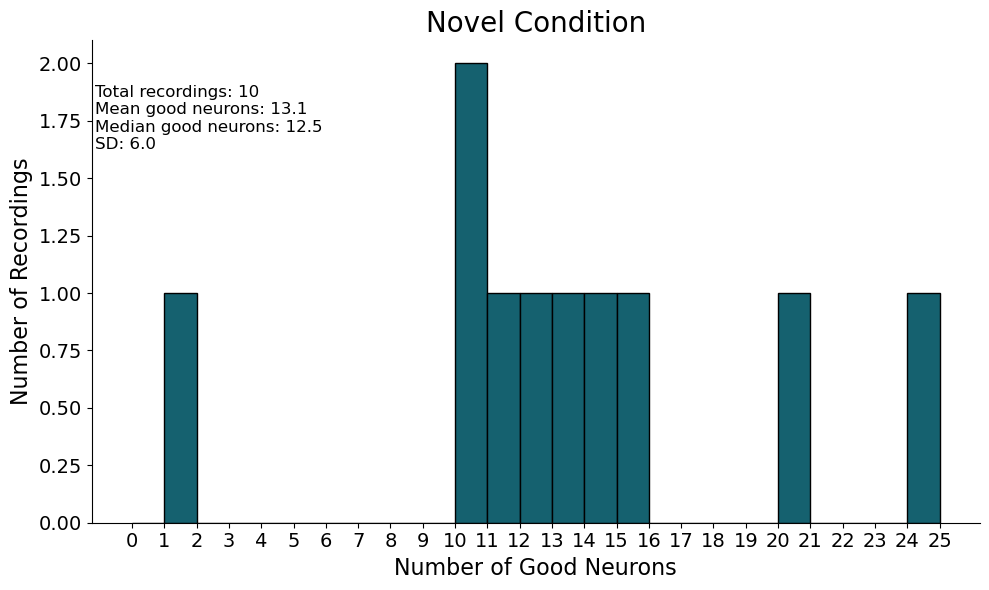

In [12]:
def plot_neuron_histogram(collection, title, color, bin_size=5):
   # Get counts of good neurons per recording
    recording_data = []

    for recording in collection.recordings:
        total = len(recording.freq_dict.keys())
        good = sum(1 for freq in recording.freq_dict.values() if freq > 0.5)
        recording_data.append({
            'recording': recording.name,
            'total_neurons': total,
            'good_neurons': good
        })

    # Create DataFrame
    df = pd.DataFrame(recording_data)
   
    # Create histogram
    plt.figure(figsize=(10, 6))

    # Calculate number of bins based on bin_size
    bins = np.arange(0, max(df['good_neurons']) + bin_size, bin_size)

    plt.hist(df['good_neurons'], bins=bins, color=color, edgecolor='black')

    # Customize plot
    plt.xlabel('Number of Good Neurons', fontsize=16)
    plt.ylabel('Number of Recordings', fontsize=16)
    plt.title(f'{title}', fontsize=20)

    # Set ticks
    plt.xticks(bins, fontsize=14)
    plt.yticks(fontsize=14)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add summary statistics as text
    plt.figtext(0.1, 0.85, 
                f'Total recordings: {len(df["good_neurons"])}\n'
                f'Mean good neurons: {np.mean(df["good_neurons"]):.1f}\n'
                f'Median good neurons: {np.median(df["good_neurons"]):.1f}\n'
                f'SD: {np.std(df["good_neurons"]):.1f}',
                fontsize=12, ha='left', va='top')

    plt.tight_layout()
    plt.show()

    return df

# Usage:
good_counts = plot_neuron_histogram(cagemate_collection, title = 'Cagemate condition', color = '#792910', bin_size=1)
good_counts_novel = plot_neuron_histogram(novel_collection, title = 'Novel Condition', color = '#15616F', bin_size = 1)

In [ ]:
good_counts

In [ ]:
good_counts_novel

# Wilcoxon: Presniff vs Sniff

In [14]:
from importlib import reload
reload(wilcox)
novel_collection.analyze(timebin = 100, ignore_freq=0.5)
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5)
event_length = 3
baseline_window = 1
offset = 0
cagemate_dfs = []
novel_dfs = []
cagemate_event_length = 2
novel_event_length_dict = {'exp1 sniff': 4.5, 'exp4 sniff':2.5, 'exp5 sniff': 4}
events = ['exp1 sniff', 'exp4 sniff', 'exp5 sniff']
# Create first event's dataframes
cagemate_merged = wilcox.wilcoxon_collection(cagemate_collection, event=events[0], event_length=event_length, baseline_window=baseline_window, offset=offset, exclude_offset=True, plot=False)
novel_merged = wilcox.wilcoxon_collection(novel_collection, event=events[0], event_length=event_length, baseline_window=baseline_window, offset=offset, exclude_offset = True, plot=False)

# Merge remaining events with suffixes
for i, event in enumerate(events[1:], 1):
   suffix = f"_{event}"
   cagemate_df = wilcox.wilcoxon_collection(cagemate_collection, event=event, event_length=cagemate_event_length, baseline_window=baseline_window, offset=offset, plot=False)
   novel_df = wilcox.wilcoxon_collection(novel_collection, event=event, event_length=novel_event_length_dict[event], baseline_window=baseline_window, offset=offset, plot=False)
   
   cagemate_merged = pd.merge(cagemate_merged, cagemate_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))
   novel_merged = pd.merge(novel_merged, novel_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))

All set to analyze
All set to analyze
Wilcoxon can't be done on 33_cage_p1_merged.rec exp1 sniff, because <6 samples
Wilcoxon can't be done on 33_cage_p1_merged.rec exp4 sniff, because <6 samples
Wilcoxon can't be done on 44_cage_p1_merged.rec exp4 sniff, because <6 samples
Wilcoxon can't be done on 12_nov_p1_merged.rec exp4 sniff, because <6 samples
Wilcoxon can't be done on 22_nov_p1_merged.rec exp4 sniff, because <6 samples
Wilcoxon can't be done on 11_cage_p1_merged.rec exp5 sniff, because <6 samples
Wilcoxon can't be done on 44_cage_p1_merged.rec exp5 sniff, because <6 samples


In [15]:
comparisons = ['exp1 sniff', 'exp4 sniff', 'exp5 sniff']
base_columns = ['Subject', 'Recording', 'original unit id']
novel_master_df = novel_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   novel_master_df[f'{comp} vs baseline'] = novel_merged[f'event1 vs event2_{comp}' if comp != 'exp1 sniff' else 'event1 vs event2']

# Create trimmed version
novel_master_df_trimmed = novel_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
novel_master_df_trimmed

,original unit id,exp1 sniff vs baseline,exp4 sniff vs baseline,exp5 sniff vs baseline
0,1,increases,not significant,not significant
1,125,not significant,not significant,not significant
2,127,not significant,not significant,not significant
3,181,not significant,not significant,not significant
4,201,not significant,not significant,not significant
...,...,...,...,...
99,42,not significant,not significant,not significant
100,47,not significant,not significant,not significant
101,5,not significant,not significant,not significant
102,6,not significant,increases,not significant


In [16]:

def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'increases') or (exp1 == 'decreases'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'increases') or (exp4 == 'decreases'):
        group = group + 'exp4'
    if (exp5 == 'increases') or (exp5 == 'decreases'):
        group = group + 'exp5'
    return group

novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 sniff vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 sniff vs baseline'],
                                                                  row['exp5 sniff vs baseline']), axis = 1)
results = novel_master_df_trimmed.groupby('cell group').count()
results

C:\Users\megha\AppData\Local\Temp\ipykernel_37896\3985153347.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 sniff vs baseline'],


,original unit id,exp1 sniff vs baseline,exp4 sniff vs baseline,exp5 sniff vs baseline
cell group,,,,
,76,76,76,76
exp1,7,7,7,7
exp1exp4exp5,1,1,1,1
exp1exp5,2,2,2,2
exp4,5,5,5,5
exp4exp5,1,1,1,1
exp5,12,12,12,12


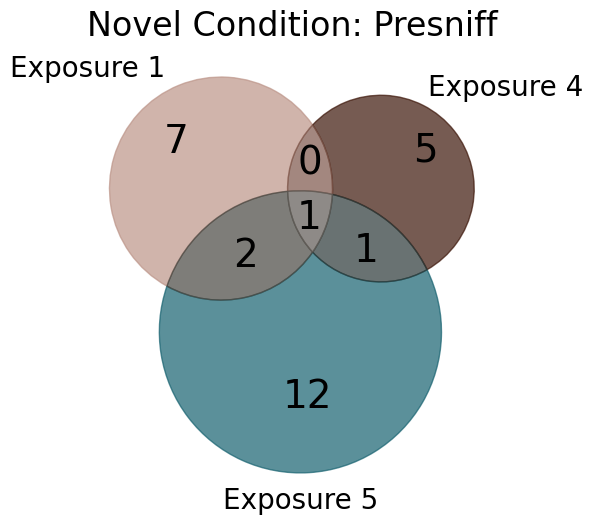

In [17]:
set1 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#bc9488') #exp 1 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#3c1508') #exp 4 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F') #exp 5 
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#7c5549') # exp 1 + exp 4
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640') #exp1 + 5 
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#2a3736') # exp 4 and 5 
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#5e5954') # all
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Novel Condition: Presniff', fontsize =24)
plt.show()

In [18]:
comparisons = ['exp1 sniff', 'exp4 sniff', 'exp5 sniff']
base_columns = ['Subject', 'Recording', 'original unit id']
cagemate_master_df = cagemate_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   cagemate_master_df[f'{comp} vs baseline'] = cagemate_merged[f'event1 vs event2_{comp}' if comp != 'exp1 sniff' else 'event1 vs event2']

# Create trimmed version
cagemate_master_df_trimmed = cagemate_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
cagemate_master_df_trimmed

,original unit id,exp1 sniff vs baseline,exp4 sniff vs baseline,exp5 sniff vs baseline
0,1,not significant,not significant,not significant
1,204,increases,increases,not significant
2,209,not significant,not significant,not significant
3,212,not significant,not significant,not significant
4,218,not significant,not significant,not significant
...,...,...,...,...
98,42,not significant,not significant,not significant
99,50,not significant,not significant,not significant
100,6,increases,not significant,not significant
101,62,not significant,not significant,not significant


In [19]:
cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 sniff vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 sniff vs baseline'],
                                                                  row['exp5 sniff vs baseline']), axis = 1)
results = cagemate_master_df_trimmed.groupby('cell group').count()
results

C:\Users\megha\AppData\Local\Temp\ipykernel_37896\503319431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 sniff vs baseline'],


,original unit id,exp1 sniff vs baseline,exp4 sniff vs baseline,exp5 sniff vs baseline
cell group,,,,
,81,81,81,81
exp1,5,5,5,5
exp1exp4,2,2,2,2
exp1exp4exp5,1,1,1,1
exp1exp5,1,1,1,1
exp4,5,5,5,5
exp5,8,8,8,8


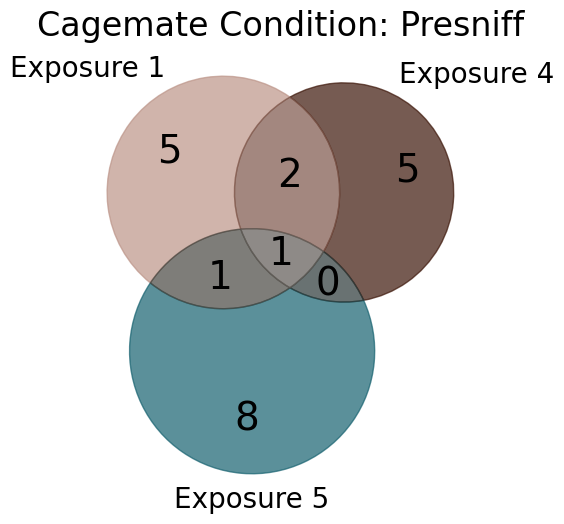

In [20]:
set1 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#bc9488') #exp 1 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#3c1508') #exp 4 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F') #exp 5 
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#7c5549') # exp 1 + exp 4
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640') #exp1 + 5 
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#2a3736') # exp 4 and 5 
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#5e5954') # all
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass
for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 

# Show the plot
plt.title('Cagemate Condition: Presniff', fontsize =24)
plt.show()

# Wilcoxon: Baseline vs Sniff

In [21]:
from importlib import reload
reload(wilcox)
novel_collection.analyze(timebin = 100, ignore_freq=0.5)
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5)
event_length = 3
baseline_window = 2
offset = 0
cagemate_dfs = []
novel_dfs = []
cagemate_event_length = 2
novel_event_length_dict = {'exp1 sniff': 4.5, 'exp4 sniff':2.5, 'exp5 sniff': 4}
events = ['exp1 sniff', 'exp4 sniff', 'exp5 sniff']
# Create first event's dataframes
cagemate_merged = wilcox.wilcoxon_event1v2_collection(cagemate_collection, event1=events[0], event2 = 'baseline', event_length=event_length, pre_window = 0, plot=False)
novel_merged = wilcox.wilcoxon_event1v2_collection(novel_collection, event1=events[0], event2 = 'baseline', event_length=event_length, pre_window = 0, plot=False)

# Merge remaining events with suffixes
for i, event in enumerate(events[1:], 1):
   suffix = f"_{event}"
   cagemate_df = wilcox.wilcoxon_event1v2_collection(cagemate_collection, event1=event, event2 = 'baseline', event_length=cagemate_event_length, pre_window = 0, plot=False)
   novel_df = wilcox.wilcoxon_event1v2_collection(novel_collection, event1=event, event2 = 'baseline', event_length=novel_event_length_dict[event], pre_window = 0, plot=False)
   
   cagemate_merged = pd.merge(cagemate_merged, cagemate_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))
   novel_merged = pd.merge(novel_merged, novel_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))

All set to analyze
All set to analyze
Wilcoxon can't be done on 33_cage_p1_merged.rec because <6 samples for either exp1 sniff or baseline
Wilcoxon can't be done on 33_cage_p1_merged.rec because <6 samples for either exp4 sniff or baseline
Wilcoxon can't be done on 44_cage_p1_merged.rec because <6 samples for either exp4 sniff or baseline
Wilcoxon can't be done on 12_nov_p1_merged.rec because <6 samples for either exp4 sniff or baseline
Wilcoxon can't be done on 22_nov_p1_merged.rec because <6 samples for either exp4 sniff or baseline
Wilcoxon can't be done on 11_cage_p1_merged.rec because <6 samples for either exp5 sniff or baseline
Wilcoxon can't be done on 44_cage_p1_merged.rec because <6 samples for either exp5 sniff or baseline


C:\Users\megha\AppData\Local\Temp\ipykernel_37896\34844699.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 sniff vs baseline'],


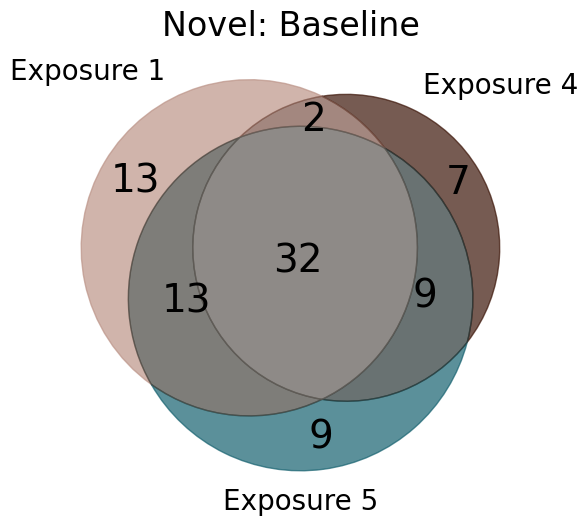

In [24]:
comparisons = ['exp1 sniff', 'exp4 sniff', 'exp5 sniff']
base_columns = ['Subject', 'Recording', 'original unit id']
novel_master_df = novel_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   novel_master_df[f'{comp} vs baseline'] = novel_merged[f'event1 vs event2_{comp}' if comp != 'exp1 sniff' else 'event1 vs event2']

# Create trimmed version
novel_master_df_trimmed = novel_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
novel_master_df_trimmed

def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'increases') or (exp1 == 'decreases'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'increases') or (exp4 == 'decreases'):
        group = group + 'exp4'
    if (exp5 == 'increases') or (exp5 == 'decreases'):
        group = group + 'exp5'
    return group

novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 sniff vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 sniff vs baseline'],
                                                                  row['exp5 sniff vs baseline']), axis = 1)
results = novel_master_df_trimmed.groupby('cell group').count()
results

set1 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))

   
try:
   venn.get_patch_by_id('100').set_color('#bc9488') #exp 1 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#3c1508') #exp 4 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F') #exp 5 
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#7c5549') # exp 1 + exp 4
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640') #exp1 + 5 
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#2a3736') # exp 4 and 5 
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#5e5954') # all
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Novel: Baseline', fontsize =24)
plt.show()

C:\Users\megha\AppData\Local\Temp\ipykernel_37896\3353748704.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 sniff vs baseline'],


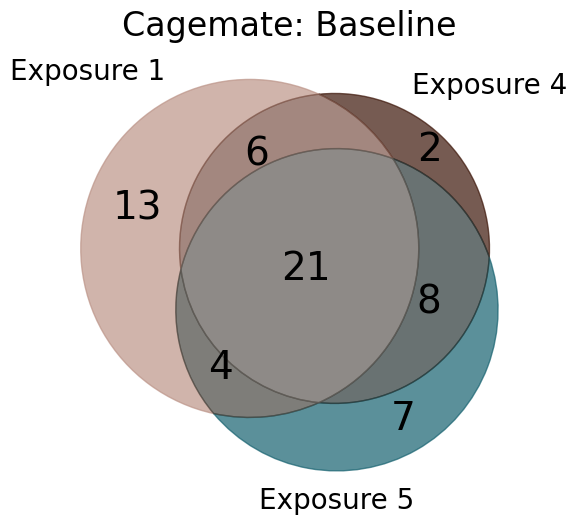

In [25]:
comparisons = ['exp1 sniff', 'exp4 sniff', 'exp5 sniff']
base_columns = ['Subject', 'Recording', 'original unit id']
cagemate_master_df = cagemate_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   cagemate_master_df[f'{comp} vs baseline'] = cagemate_merged[f'event1 vs event2_{comp}' if comp != 'exp1 sniff' else 'event1 vs event2']

# Create trimmed version
cagemate_master_df_trimmed = cagemate_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
cagemate_master_df_trimmed

def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'increases') or (exp1 == 'decreases'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'increases') or (exp4 == 'decreases'):
        group = group + 'exp4'
    if (exp5 == 'increases') or (exp5 == 'decreases'):
        group = group + 'exp5'
    return group

cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 sniff vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 sniff vs baseline'],
                                                                  row['exp5 sniff vs baseline']), axis = 1)
results = cagemate_master_df_trimmed.groupby('cell group').count()
results

set1 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#bc9488') #exp 1 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#3c1508') #exp 4 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F') #exp 5 
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#7c5549') # exp 1 + exp 4
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640') #exp1 + 5 
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#2a3736') # exp 4 and 5 
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#5e5954') # all
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Cagemate: Baseline', fontsize =24)
plt.show()

# auROC

In [44]:
from importlib import reload
reload(wilcox)

cagemate_collection.analyze(timebin = 100, ignore_freq= 0.5)
bootstrap_results_cagemate = wilcox.bootstrap(cagemate_collection, ['exp1 sniff', 'exp4 sniff', 'exp5 sniff'], 3, pre_window = 0, num_perm = 2000)

All set to analyze


In [ ]:
from importlib import reload
reload(wilcox)

novel_collection.analyze(timebin = 100, ignore_freq= 0.5)
bootstrap_results_novel = wilcox.bootstrap(novel_collection, ['exp1 sniff', 'exp4 sniff', 'exp5 sniff'], 3, pre_window = 0, num_perm = 2000)

All set to analyze


In [45]:
bootstrap_results_cagemate.to_csv('pilot2/habit_dishabit_phase1/bootstrap_exp1_4_5_cagemate.csv')

In [ ]:
bootstrap_results.to_csv('pilot2/habit_dishabit_phase1/bootstrap_exp1_4_5_novel.csv')

In [ ]:
#bootstrap_results_cagemate = pd.read_csv(r'pilot2\habit_dishabit_phase1\outputs\bootstrap_exp1_4_5_cagemate.csv')


In [30]:
bootstrap_results_novel = bootstrap_results

In [32]:


def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'significantly increased') or (exp1 == 'significantly decreased'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'significantly increased') or (exp4 == 'significantly decreased'):
        group = group + 'exp4'
    if (exp5 == 'significantly increased') or (exp5 == 'significantly decreased'):
        group = group + 'exp5'
    return group

bootstrap_results_novel['cell group'] = bootstrap_results_novel.apply(lambda row: group_cells(row['exp1 sniff'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 sniff'],
                                                                  row['exp5 sniff']), axis = 1)
results = bootstrap_results_novel.groupby('cell group').count()
results



,original_unit_id,recording,exp1 sniff,exp4 sniff,exp5 sniff
cell group,,,,,
,8,8,8,8,8
exp1,2,2,2,2,2
exp1exp4,13,13,13,13,13
exp1exp4exp5,56,56,56,56,56
exp1exp5,24,24,24,24,24
exp4,4,4,4,4,4
exp4exp5,16,16,16,16,16
exp5,8,8,8,8,8


In [ ]:
bootstrap_results_novel

In [ ]:
def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'significantly increased') or (exp1 == 'significantly decreased'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'significantly increased') or (exp4 == 'significantly decreased'):
        group = group + 'exp4'
    if (exp5 == 'significantly increased') or (exp5 == 'significantly decreased'):
        group = group + 'exp5'
    return group

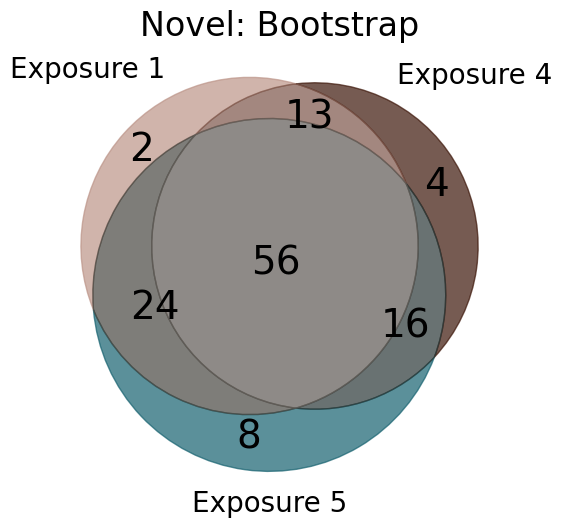

In [33]:
set1 = set(bootstrap_results_novel.index[bootstrap_results_novel['cell group'].str.contains('exp1')])
set2 = set(bootstrap_results_novel.index[bootstrap_results_novel['cell group'].str.contains('exp4')])
set3 = set(bootstrap_results_novel.index[bootstrap_results_novel['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#bc9488') #exp 1 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#3c1508') #exp 4 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F') #exp 5 
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#7c5549') # exp 1 + exp 4
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640') #exp1 + 5 
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#2a3736') # exp 4 and 5 
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#5e5954') # all
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass



    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Novel: Bootstrap', fontsize =24)
plt.show()

In [37]:
#values = exp1 increase - exp4 increase , exp1 increase - exp4 decrease , exp1 increase - exp4 no change
values = []
meaning = []
for exposure in ['exp1 sniff', 'exp4 sniff']:
    for conditionA in ["significantly increased", "significantly decreased", "not significantly changed"]:
        temp = bootstrap_results_novel[bootstrap_results_novel[exposure] == conditionA]
        for conditionB in ["significantly increased", "significantly decreased", "not significantly changed"]:
            if exposure == 'exp1 sniff':
                values.append(int(temp['exp4 sniff'].value_counts()[conditionB]))
                meaning.append(exposure + conditionA + 'exp4 sniff' + conditionB) 
            if exposure == 'exp4 sniff':
                values.append(temp['exp5 sniff'].value_counts()[conditionB])
                meaning.append(exposure + conditionA + 'exp5 sniff' + conditionB) 
print(values)
print(meaning)

[6, 22, 10, 28, 13, 16, 10, 10, 16, np.int64(24), np.int64(13), np.int64(7), np.int64(11), np.int64(24), np.int64(10), np.int64(9), np.int64(23), np.int64(10)]
['exp1 sniffsignificantly increasedexp4 sniffsignificantly increased', 'exp1 sniffsignificantly increasedexp4 sniffsignificantly decreased', 'exp1 sniffsignificantly increasedexp4 sniffnot significantly changed', 'exp1 sniffsignificantly decreasedexp4 sniffsignificantly increased', 'exp1 sniffsignificantly decreasedexp4 sniffsignificantly decreased', 'exp1 sniffsignificantly decreasedexp4 sniffnot significantly changed', 'exp1 sniffnot significantly changedexp4 sniffsignificantly increased', 'exp1 sniffnot significantly changedexp4 sniffsignificantly decreased', 'exp1 sniffnot significantly changedexp4 sniffnot significantly changed', 'exp4 sniffsignificantly increasedexp5 sniffsignificantly increased', 'exp4 sniffsignificantly increasedexp5 sniffsignificantly decreased', 'exp4 sniffsignificantly increasedexp5 sniffnot significa

In [38]:
names = ["significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change"]
targets = ["significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change",
                "significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change"]
color_dict = {'increased':'red','decreased':'blue','change':'grey'}
color_dict_links = {"increased":"#FFDCDC", 'decreased': "#DCE5FF", 'change':  "#DBDBDB"}
fig = go.Figure(data=[go.Sankey(
    node = dict(
        label = names,             # Third stage
        pad = 15,
        thickness = 20,
        color = [color_dict[x.split(' ')[-1]] for x in names],
         y = [0.15, 0.49, 0.85,     # First stage (A_1, B_1, C_1)
            0.18, 0.51, 0.84,     # Second stage (A_2, B_2, C_2) 
            0.18, 0.55, 0.88],    # Third stage (A_3, B_3, C_3)
       # x positions to space out stages
        x = [0.1, 0.1, 0.1,       # First stage
            0.5, 0.5, 0.5,       # Second stage
            0.9, 0.9, 0.9] 
    ),
    link = dict(
        # First stage to second stage
        source = [0, 0, 0,          # Math101 to Pass/Fail
                 1, 1, 1,
                 2, 2, 2,
                 3, 3, 3, 
                 4, 4, 4, 
                 5, 5, 5],          # Physics101 to Pass/Fail
        target = [3, 4, 5,          # to Pass Math/Fail Math
                 3, 4, 5,
                 3, 4, 5,
                 6, 7, 8,
                 6, 7, 8,
                 6, 7, 8],          # to Pass Physics/Fail Physics
        value = values,  
        color = [color_dict_links[x.split(' ')[-1]] for x in targets],
         
      
               # 70 pass physics, 30 fail
    )
)])
fig.update_layout(
    annotations=[
        # First group title
        dict(
            x=-0.05,  # x position (0 to 1)
            y=1.1,  # y position above the plot
            xref="paper",
            yref="paper",
            text="Exposure 1",
            showarrow=False,
            font=dict(size=16)
        ),
        # Second group title
        dict(
            x=0.5,
            y=1.1,
            xref="paper",
            yref="paper",
            text="Exposure 4",
            showarrow=False,
            font=dict(size=16)
        ),
        # Third group title
        dict(
            x=1.05,
            y=1.1,
            xref="paper",
            yref="paper",
            text="Exposure 5",
            showarrow=False,
            font=dict(size=16)
        ),
        dict(
            x=.5,
            y=1.3,
            xref="paper",
            yref="paper",
            text="Novel",
            showarrow=False,
            font=dict(size=24)
        )
    ],
    # Add more top margin to make room for labels
    margin=dict(t=100)
)

fig.show()

In [ ]:
# bootstrap_results = pd.read_csv(r'pilot2\habit_dishabit_phase1\outputs\bootstrap_exp1_4_5_cagemate.csv')
# bootstrap_results

,Unnamed: 0,original_unit_id,recording,exp1,exp4,exp5,cell group
0,0,2,11_cage_p1_merged.rec,signifcantly increased,signifcantly increased,signifcantly increased,exp1exp4exp5
1,1,235,11_cage_p1_merged.rec,signifcantly decreased,signifcantly increased,signifcantly increased,exp1exp4exp5
2,2,75,11_cage_p1_merged.rec,not significantly changed,signifcantly decreased,signifcantly decreased,exp4exp5
3,3,104,11_cage_p1_merged.rec,signifcantly decreased,signifcantly decreased,signifcantly decreased,exp1exp4exp5
4,4,61,11_cage_p1_merged.rec,signifcantly increased,not significantly changed,signifcantly decreased,exp1exp5
...,...,...,...,...,...,...,...
129,129,10,44_cage_p1_merged.rec,not significantly changed,signifcantly increased,signifcantly increased,exp4exp5
130,130,55,44_cage_p1_merged.rec,signifcantly increased,not significantly changed,signifcantly increased,exp1exp5
131,131,86,44_cage_p1_merged.rec,not significantly changed,not significantly changed,not significantly changed,NaN
132,132,18,44_cage_p1_merged.rec,signifcantly decreased,signifcantly increased,signifcantly increased,exp1exp4exp5


In [40]:
def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'signifcantly increased') or (exp1 == 'signifcantly decreased'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'signifcantly increased') or (exp4 == 'signifcantly decreased'):
        group = group + 'exp4'
    if (exp5 == 'signifcantly increased') or (exp5 == 'signifcantly decreased'):
        group = group + 'exp5'
    return group

In [43]:
bootstrap_results_cagemate['cell group'] = bootstrap_results_cagemate.apply(lambda row: group_cells(row['exp1 sniff'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 sniff'],
                                                                  row['exp5 sniff']), axis = 1)
results = bootstrap_results_cagemate.groupby('cell group').count()
results

,original_unit_id,recording,exp1 sniff,exp4 sniff,exp5 sniff
cell group,,,,,
,134,134,134,134,134


In [ ]:
set1 = set(bootstrap_results.index[bootstrap_results['cell group'].str.contains('exp1')])
set2 = set(bootstrap_results.index[bootstrap_results['cell group'].str.contains('exp4')])
set3 = set(bootstrap_results.index[bootstrap_results['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#bc9488') #exp 1 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#3c1508') #exp 4 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F') #exp 5 
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#7c5549') # exp 1 + exp 4
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640') #exp1 + 5 
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#2a3736') # exp 4 and 5 
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#5e5954') # all
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Cagemate: Bootstrap', fontsize =24)
plt.show()

In [ ]:
bootstrap_results[bootstrap_results['exp4'] == 'not significantly changed']

In [ ]:
names = ["significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change"]
targets = ["significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change",
                "significantly increased", "significantly decreased", "no change",           # First stage
                "significantly increased", "significantly decreased", "no change",  
                " significantly increased", " significantly decreased", " no change"]
color_dict = {'increased':'red','decreased':'blue','change':'grey'}
color_dict_links = {"increased":"#FFDCDC", 'decreased': "#DCE5FF", 'change':  "#DBDBDB"}
fig = go.Figure(data=[go.Sankey(
    node = dict(
        label = names,             # Third stage
        pad = 15,
        thickness = 20,
        color = [color_dict[x.split(' ')[-1]] for x in names] ,
        y = [0.15, 0.45, 0.82,     # First stage (A_1, B_1, C_1)
            0.15, 0.45, 0.82,     # Second stage (A_2, B_2, C_2) 
            0.185, 0.52, 0.85],    # Third stage (A_3, B_3, C_3)
       # x positions to space out stages
        x = [0.1, 0.1, 0.1,       # First stage
            0.5, 0.5, 0.5,       # Second stage
            0.9, 0.9, 0.9] 
    ),
    link = dict(
        # First stage to second stage
        source = [0, 0, 0,          # Math101 to Pass/Fail
                 1, 1, 1,
                 2, 2, 2,
                 3, 3, 3, 
                 4, 4, 4, 
                 5, 5, 5],          # Physics101 to Pass/Fail
        target = [3, 4, 5,          # to Pass Math/Fail Math
                 3, 4, 5,
                 3, 4, 5,
                 6, 7, 8,
                 6, 7, 8,
                 6, 7, 8],          # to Pass Physics/Fail Physics
        value = [15, 3, 18,        # 80 pass math, 20 fail
                12, 16, 15,         #sig inc, sig dec, no change
                12, 20, 23,
                25, 3, 11,
                6, 21, 12,
                18, 13, 25],  
        color = [color_dict_links[x.split(' ')[-1]] for x in targets],
        
      
               # 70 pass physics, 30 fail
    )
)])
fig.update_layout(
    annotations=[
        # First group title
        dict(
            x=-0.05,  # x position (0 to 1)
            y=1.1,  # y position above the plot
            xref="paper",
            yref="paper",
            text="Exposure 1",
            showarrow=False,
            font=dict(size=16)
        ),
        # Second group title
        dict(
            x=0.5,
            y=1.1,
            xref="paper",
            yref="paper",
            text="Exposure 4",
            showarrow=False,
            font=dict(size=16)
        ),
        # Third group title
        dict(
            x=1.05,
            y=1.1,
            xref="paper",
            yref="paper",
            text="Exposure 5",
            showarrow=False,
            font=dict(size=16)
        ),
        dict(
            x=.5,
            y=1.3,
            xref="paper",
            yref="paper",
            text="Cagemate",
            showarrow=False,
            font=dict(size=24)
        )
    ],
    # Add more top margin to make room for labels
    margin=dict(t=100)
)

fig.show()

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
        label = ["A_1", "B_1",           # First stage
                "A_2", "B_2",            # Second stage
                "A_3", "B_3"],           # Third stage
        # You can customize how they display
        customdata = ["A", "B",          # What you actually want to show
                     "A", "B",
                     "A", "B"],
        # Use hovertemplate to show the customdata instead of the internal labels
        hovertemplate='%{customdata}<br />Value: %{value}<extra></extra>',
        pad = 15,
        thickness = 20,
    ),
    link = dict(
        source = [0, 0, 1, 1,        # First to second stage (A_1->A_2/B_2, B_1->A_2/B_2)
                 2, 2, 3, 3],        # Second to third stage (A_2->A_3/B_3, B_2->A_3/B_3)
        target = [2, 3, 2, 3,        # To second stage
                 4, 5, 4, 5],        # To third stage
        value = [80, 20, 70, 30,     # First to second flows
                75, 5, 65, 25]       # Second to third flows
    )
)])

fig.update_layout(title_text="Alluvial Diagram with Repeated Labels")
fig.show()

In [ ]:
import plotly.graph_objects as go

# fig = go.Figure(data=[go.Sankey(
#     node = dict(
#         label = ["Math101", "Physics101",           # First stage
#                 "Pass Math", "Fail Math",           # Second stage
#                 "Pass Physics", "Fail Physics",     
#                 "Graduate", "Dropout"],             # Third stage
#         pad = 15,
#         thickness = 20,
#     ),
#     link = dict(
#         # First stage to second stage
#         source = [0, 0,          # Math101 to Pass/Fail
#                  1, 1],          # Physics101 to Pass/Fail
#         target = [2, 3,          # to Pass Math/Fail Math
#                  4, 5],          # to Pass Physics/Fail Physics
#         value = [80, 20,         # 80 pass math, 20 fail
#                 70, 30],         # 70 pass physics, 30 fail
#     )
# )])

# You can also add flows from second stage to third stage:
fig = go.Figure(data=[go.Sankey(
    node = dict(
        label = ["Math101", "Physics101", 
                "Pass Math", "Fail Math", "Pass Physics", "Fail Physics",
                "Graduate", "Dropout"],
        pad = 15,
        thickness = 20,
    ),
    link = dict(
        source = [0, 0, 1, 1,        # First to second stage
                 2, 3, 4, 5],        # Second to third stage
        target = [2, 3, 4, 5,        # To second stage
                 6, 7, 6, 7],        # To third stage
        value = [80, 20, 70, 30,     # First to second flows
                75, 5, 65, 25]       # Second to third flows
    )
)])

fig.show()

In [ ]:
import importlib
import spike.spike_analysis.normalization
importlib.reload(wilcox)
importlib.reload(spike.spike_analysis.normalization)
novel_collection.analyze(timebin=100)
wilcox.plot_raster(novel_collection, event = 'exp1', event_length = 2, pre_window = 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LogNorm

def plot_raster_whole_recording(spike_collection):
    arrays = []
    for recording in spike_collection.recordings:
        arrays.append(recording.unit_firing_rate_array)
    min_length = min(arr.shape[0] for arr in arrays)
# Trim all arrays to this length
    trimmed_arrays = []
    for unit_array in arrays:
        trimmed = unit_array[:min_length, :]
        trimmed_arrays.append(trimmed)
    firing_rate_array = np.hstack(trimmed_arrays)
    print(firing_rate_array.shape)
    #time x neurons= samples by features
    scaler = StandardScaler()
    zscore_matrix = scaler.fit_transform(firing_rate_array)
    other_way = scaler.fit_transform(firing_rate_array)
    #row_means = np.mean(firing_rate_array, axis=1)
    #sort_indices = np.argsort(row_means)[::-1]

    # Reorder the data
    #sorted_zscore = zscore_matrix[sort_indices]
    timebin_s = spike_collection.timebin / 1000 / 60 # Convert timebin from ms to seconds
    total_bins = zscore_matrix.shape[1] 
    time_axis = np.linspace(0, min_length/600, total_bins)

    # Create the plot
    fig, ax = plt.subplots(figsize=(30, 10))

    # Plot heatmap
    im = ax.imshow(other_way.T, aspect="auto", cmap="viridis", extent=[time_axis[0], time_axis[-1], zscore_matrix.shape[0], 0], vmax = 5)
    
    # Add event rectangle (from 0 to event_length in seconds)
    import matplotlib.patches as patches

 

    # Customize plot
    plt.colorbar(im, label="Z-score")
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Units (sorted by mean activity)")
    ax.set_title("Neural Activity Aligned to Event Onset")

  

    plt.tight_layout()
    plt.show()
plot_raster_whole_recording(cagemate_collection)
plot_raster_whole_recording(novel_collection)